In [34]:
from sklearn.cluster import KMeans
from collections import Counter
from matplotlib import pyplot as plt
import cv2
%matplotlib inline


Most dominant color finder
--
this function is used to find the most dominant color or the blend of most dominant color out for the image

- this program uses kmean clustering to find the most dominat color of all
- the default cluster are taken to be 6 ie predicts the blend of 6 most dominat colors but for our program we take 2 so we get white and the most dominant fruit color
- the color found form this functionis used to fill the fruit image 

In [35]:
def findmin(arr):
    arr1=[0,0]
    for i in range (0,2):
        a0=arr[i][0]
        a1=arr[i][1]
        a2=arr[i][2]
        arr1[i]=abs(a0-a1)+abs(a0-a2)+abs(a1-a2)
    if(arr1[0]<arr1[1]):
        return arr[1]
    else:
        return arr[0]
    
def rgb2hex(rgb):
    hex = "#{:02x}{:02x}{:02x}".format(int(rgb[0]), int(rgb[1]), int(rgb[2]))
    return hex
  

def plot_image_info(path, k=6 ,show=False):

    img_bgr = cv2.imread(path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    resized_img_rgb = cv2.resize(img_rgb, (64, 64), interpolation=cv2.INTER_AREA)

    img_list = resized_img_rgb.reshape((resized_img_rgb.shape[0] * resized_img_rgb.shape[1], 3))

    clt = KMeans(n_clusters=k)
    labels = clt.fit_predict(img_list)

    label_counts = Counter(labels)
    total_count = sum(label_counts.values())

    center_colors = list(clt.cluster_centers_)
    ordered_colors = [center_colors[i]/255 for i in label_counts.keys()]
    color_labels = [rgb2hex(ordered_colors[i]*255) for i in label_counts.keys()]
    arr=[ordered_colors[i]*255 for i in label_counts.keys()]

    if(show):

        plt.figure(figsize=(14, 8))
        plt.subplot(221)
        plt.imshow(img_rgb)
        plt.axis('off')

        plt.subplot(222)
        plt.pie(list(label_counts.values()), labels=color_labels, colors=ordered_colors)
        plt.axis('equal')
        plt.show()
    return arr
   
def getcolor(path):
    arr=plot_image_info(path,2)
    return(findmin(arr))

In [36]:
from skimage import io
from skimage import feature
from skimage.color import rgb2gray
import os
from glob import glob
import numpy as np

ENCLOSED AREA FINDER
--
this whole function is to join the edges of the image so that it can the find the inside pixels to replace with dominat color
here this function

- `takes the image then converts it into rgb then to grayscale` 
- `then finds its border edges`
- `thickens edges which are nessary and simultaneously removes any noise/unnessary edges present`
- `then joins the edges and create a closed encolsure` 
- `removes extra pixelated values outside the outer edge`
- `sends the processed enclose area to which dominant color can be added`

In [37]:
def edge_grave(x1,x2,x4,col):
    x3 = [[ x1[y][x] for x in range(len(x1[0]))] for y in range(len(x1))] 
    for i in range(0,len(x1)):
        for j in range(0,len(x1[0])):
            if(x2[i][j][0]==255 and x2[i][j][1]==255 and x2[i][j][2]==255):
                x3[i][j]=[0,0,0]
            elif(not x4[i][j]):
                x3[i][j][0]=round(col[0])
                x3[i][j][1]=round(col[1])
                x3[i][j][2]=round(col[2])
            else:
                x3[i][j]=x1[i][j]
                
    return x3  
def pointc(img,x,y,m=3,n=3,t=3):
    k=0
    #l=-1*int(z/2)
    #m=int(z/2)+1
    for i in range(-1*int(m/2),int(m/2)+1):
         for j in range(-1*int(n/2),int(n/2)+1):
                if((x+i)<100 and (y+j)<100 and (x+i)>0 and (y+j)>0):
                    if(img[x+i][y+j]):
                        k=k+1
    if(k>t):
        return True
    else:
        return False

def lastt(img,x,d='h',t='l'):
    y=0
    if(d=='h' and t=='l'):
        for i in range(0,100):
            if(img[x][i]):
                y=i
    elif(d=='h' and t=='f'):
        for i in range(0,100):
            if(img[x][i]):
                y=i
                break
    elif(d=='v' and t=='l'):
        for i in range(0,100):
            if(img[i][x]):
                y=i
    elif(d=='v' and t=='f'):
        for i in range(0,100):
            if(img[i][x]):
                y=i
                break            
    return y    

def prepro(img,m=3,n=3,t=3,rem=True):
    img1=np.array([[img[x][y] for y in range(100)] for x in range(100)])   
    for i in range(0,100):
        for j in range(0,100):
            if(pointc(img,i,j,m,n,t)):
                img1[i][j]=True
            elif(rem):
                img1[i][j]=False
    return img1   

def fill(img):
    img1=np.array([[img[x][y] for y in range(100)] for x in range(100)])   
    flag=False
    for i in range(0,100):
        flag=False
        ll=lastt(img,i)
        for j in range(0,98):
            if(img[i][j]==True):
                if(pointc(img,i,j) or True):
                    if((img[i][j+1]==False)): 
                        flag= not flag
                    else:
                        img[i][j]=False
            else:
                if(flag):
                    if(not img[i][j] and j<ll):
                        img1[i][j]=True
            
    return img1         

def fill2(img1):
    arr=[]
    img=np.array([[img1[x][y] for y in range(100)] for x in range(100)]) 
    #horizontal fill f
    for i in range(0,100):
        for j in range(0,lastt(img1,i,'h','f')):
            img[i][j]=True
    #horizontal fill l
    for i in range(0,100):
        for j in range(lastt(img1,i,'h','l'),100):
            img[i][j]=True
    #vertical fill l
    for i in range(0,100):
        for j in range(lastt(img1,i,'v','l'),100):
            img[j][i]=True        
    #vertical fill f
    for i in range(0,100):
        arr+=[lastt(img1,i,'h','f')]
        for j in range(0,lastt(img1,i,'v','f')):
            img[j][i]=True      
    return img   


def getfill(path):
    image = io.imread(path)
    gray = rgb2gray(image)
    edges1 = feature.canny(gray, 0.2, 0.75, 0.4)
    edges1=prepro(edges1,4,4,2)
    edges1=prepro(edges1,1,10,3,False)
    edges1=prepro(edges1,1,10,3,False)
    return(fill2(edges1))

In [38]:
from skimage import io
from skimage import feature
from skimage.color import rgb2gray
import os
from glob import glob

In [39]:
def convert(img):
    img=rgb2gray(img)
    img = feature.canny(img, 0.1, 0.2, 0.25)
    return img

def change(img):
    a=[]
    for i in img:
        s=[]
        for j in i:
            if j:
                s=s+[[255,255,255]]
            else:
                s=s+[[0,0,0]]
        a=a+[s]    
    return a

In [62]:
def edge_grave(x1,x2,x4,col):
    x3 = [[ x1[y][x] for x in range(len(x1[0]))] for y in range(len(x1))] 
    for i in range(0,len(x1)):
        for j in range(0,len(x1[0])):
            if(x2[i][j][0]==255 and x2[i][j][1]==255 and x2[i][j][2]==255):
                x3[i][j]=[0,0,0]
            elif(not x4[i][j]):
                x3[i][j][0]=round(col[0])
                x3[i][j][1]=round(col[1])
                x3[i][j][2]=round(col[2])
            else:
                x3[i][j]=x1[i][j]
                
    return x3  

def load_images(base_path):
    images = []
    path = os.path.join(base_path, '*.jpg')
    for image_path in glob(path):
        #image1 = preprocessing.image.load_img(image_path,target_size=(width, height))
        #x1 = preprocessing.image.img_to_array(image1)
        #image2 = preprocessing.image.load_img(image_path.replace(name,name+'_edge'),target_size=(width, height))
        #x2 = preprocessing.image.img_to_array(image2)
        #images.append([x1,x2])
        x1=io.imread(image_path)
        x2=convert(x1)
        x2=change(x2)
        x3=getfill(image_path)
        col=getcolor(image_path)
        #col=[ round(col[i]) for i in range(3) ]
        x5=edge_grave(x1,x2,x3,col)
        path1=image_path.replace('data','processed_data')
        io.imsave(path1,np.array(x5))

In [40]:
def dircreate(path):
    try:  
        os.makedirs(path)
    except OSError:  
        print ("Creation of the directory %s failed" % path)
    else:  
        print ("Successfully created the directory %s" % path)

In [41]:
def call(fruits):
    for i in fruits:
        base_path='./data/'+i
        dircreate('./processed_data/'+i)
        load_images(base_path)

In [63]:
fruits=['Apple','Banana','Mango','Kiwi','Lime']
fruuu=['test']

call(fruuu)

Creation of the directory ./processed_data/test failed


In [64]:
load_images('./data')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: ./processed_data/4.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: ./processed_data/5.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to ui

In [44]:
col=getcolor('./data/1.jpg')
round(col[1])

66.0

In [45]:
x1=io.imread('./data/1.jpg')
x2=convert(x1)
x2=change(x2)

In [46]:
print(x3)

[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


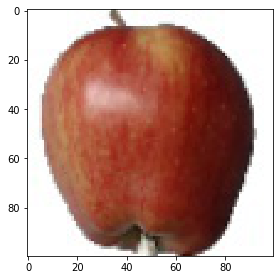

In [49]:
x1=io.imread("./data/1.jpg")
io.imshow(x1)

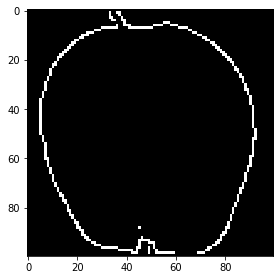

In [50]:
x1=io.imread("./data/1.jpg")
x2=convert(x1)
x2=feature.canny(rgb2gray(x1),0.8, 0.7, 0)
io.imshow(x2)
x2=change(x2)

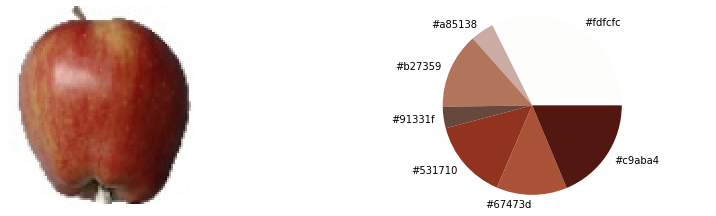

In [51]:
col1=plot_image_info("./test.jpg", 7,True)
col=getcolor("./test.jpg")

In [52]:
#image = io.imread(path)
gray = rgb2gray(x1)
#edges1=feature.canny(gray, 0.2, 0.75, 0.4)
edges1=feature.canny(gray, 0.2, 0.75, 0/4)
edges2=prepro(edges1,4,4,2)
edges3=prepro(edges2,2,10,3,False)
edges4=prepro(edges3,1,10,3,False)
x3=fill2(edges4)

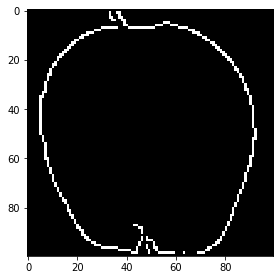

In [53]:
io.imshow(edges1)


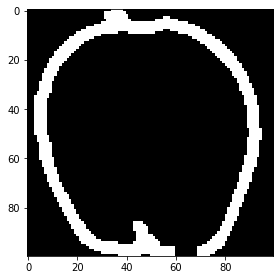

In [54]:
io.imshow(edges2)

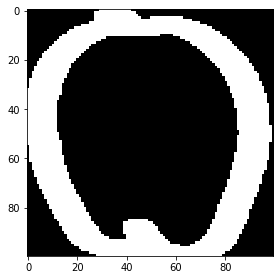

In [55]:
io.imshow(edges3)

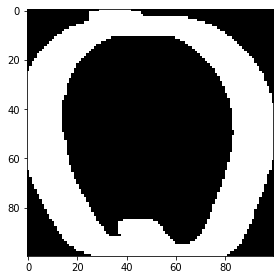

In [56]:
io.imshow(edges4)

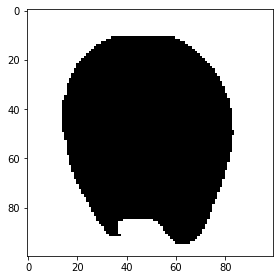

In [57]:
io.imshow(x3)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:75: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


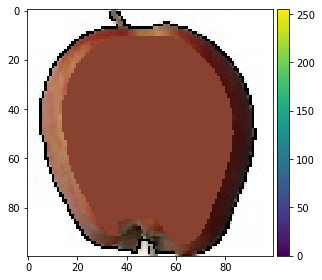

In [58]:
io.imshow(np.array(edge_grave(x1,x2,x3,col)))

In [60]:
io.imsave("./result.jpg",np.array(edge_grave(x1,x2,x3,col)))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: ./result.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


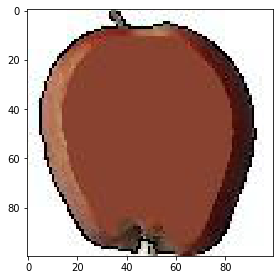

In [61]:
io.imshow(io.imread("./result.jpg"))